In [ ]:
# !pip install transformers
# !pip install datasets
# !pip install -q sentencepiece
# !pip install rouge-score

In [25]:
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "/content/gdrive/MyDrive/Classes/W266_NLP/w266_reddit_summarization/data/tensorflow_datasets/reddit/1.0.0"
os.chdir(data_dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
file_names = os.listdir(data_dir)
metadata_files = [i for i in file_names if re.search('^(?!reddit-train)', i)]
train_records = [i for i in file_names if re.search('^reddit-train', i)]

In [13]:
def parse_file(serialized_example):

  file_scruct = {
      'author': tf.io.FixedLenFeature([], tf.string),
      'body': tf.io.FixedLenFeature([], tf.string),
      'content': tf.io.FixedLenFeature([], tf.string),
      'id': tf.io.FixedLenFeature([], tf.string),
      'normalizedBody': tf.io.FixedLenFeature([], tf.string),
      'subreddit': tf.io.FixedLenFeature([], tf.string),
      'subreddit_id': tf.io.FixedLenFeature([], tf.string),
      'summary': tf.io.FixedLenFeature([], tf.string),
  }

  example1 = tf.io.parse_single_example(serialized_example, file_scruct)
  return example1

# parse: (just do 5 files for now)
dataset = tf.data.TFRecordDataset(train_records[:5]).map(parse_file)
data_dict = {'id': [], 'author': [], 'subreddit': [], 'content': [], 'summary': []}
keys_to_parse = ['id', 'author', 'subreddit', 'content', 'summary']

for item in tqdm(dataset):
  for key1 in keys_to_parse:
    data_dict[key1].append(item[key1])

# for item in enumerate(tqdm(dataset)):
#   for key1 in keys_to_parse:
#     data_dict[key1].append(item[key1])

75162it [00:37, 1991.59it/s]


In [14]:
data_dict.keys()

dict_keys(['id', 'author', 'subreddit', 'content', 'summary'])

75162

'Here is something Olympic middle distance runner Nick Willis wrote about fellow Kiwi Sean Adams (Pitt) \n New Zealand has only ever had two players reach the lofty heights of the NBA. Sean marks, a 6”11 center, was the 44th draft pick in the 1998 NBA draft, and went on to play for six different teams over his 11 season career. Kirk Penny, the former New Zealand Breakers star, went un-drafted in 2003, but had a taste of the NBA game in small stints with the Miami Heat and Los Angeles Clippers. \n Basketball fans in New Zealand look once again to have a kiwi to cheer for on the American hardwood. Rotorua native, Steven Adams, has chosen to forgo his remaining three seasons of eligibility in the NCAA as a 7ft center for Pittsburgh, and declare for this years NBA draft. Pittsburgh fans were hearing whispers of the possibility of Adams being a “one and done” prospect when he first arrived on campus, but as his first season progressed, there was a sense around the program that he may choose

In [19]:
# pegasus fine tune

model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-reddit_tifu", from_pt=True)
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-reddit_tifu")

# other pegasus ones to try:
## google/pegasus-reddit_tifu (have to include from_pt=True)
## google/pegasus-xsum
## google/pegasus-large

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

In [23]:
content_len = [len(tokenizer.encode(data_dict['content'][i].numpy().decode())) for i in range(len(data_dict['id']))]
summary_len = [len(tokenizer.encode(data_dict['summary'][i].numpy().decode())) for i in range(len(data_dict['id']))]

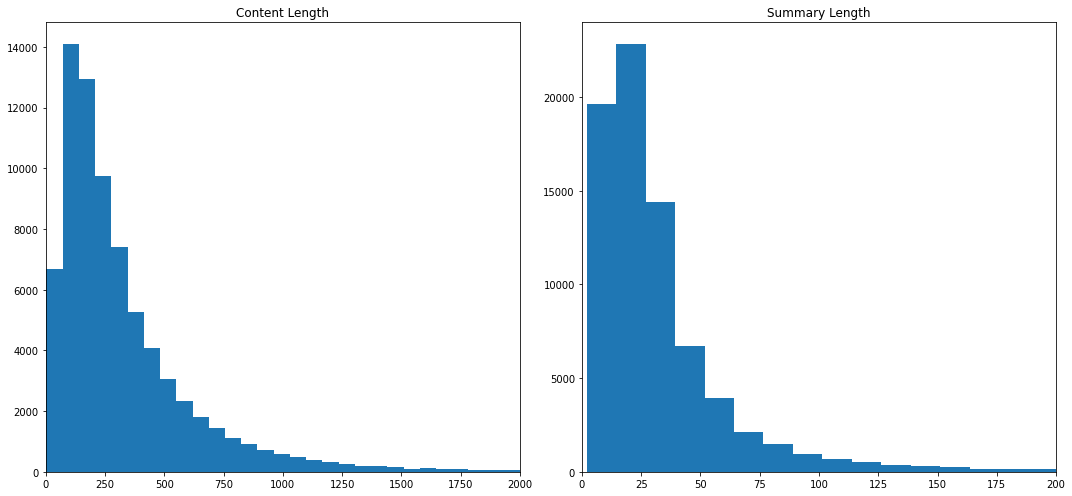

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (15,7)) 

ax[0].hist(content_len, bins=100)
ax[0].set_xlim(0, 2000)
ax[0].title.set_text("Content Length")

ax[1].hist(summary_len, bins=200)
ax[1].set_xlim(0, 200)
ax[1].title.set_text("Summary Length")

fig.tight_layout()